In [1]:
import pandas as pd
import numpy as np
import joblib
import os
import configparser as cp
from sqlalchemy import create_engine
import mysql.connector
import datetime

from plotnine import *
os.getcwd()

'/home/ubuntu/Python_Projects/Stock_Price_Prediction'

In [6]:
config=cp.ConfigParser()
config.read('/home/ubuntu/certi/db_login.txt')
db_config=config['ivan_db']
engine=create_engine('mysql+mysqlconnector://{0:s}:{1:s}@{2:s}/{3:s}'.format(db_config['userid'],
                                                                             db_config['pwd'],
                                                                             db_config['hostname'],
                                                                             'STOCK_PRED'))

# Data Loading

### Raw Data 

In [2]:
## Raw Data
df=joblib.load('/home/ubuntu/Python_Projects/Stock_Price_Prediction/data/stock_price_2020_2021.pkl')
print(df.shape)
print(df.REFRESH_DATE.min())
print(df.Stock.nunique())
df.dtypes

(2178988, 9)
2021-08-15 00:00:00
5991


Date            datetime64[ns]
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                 float64
SE                      object
Stock                   object
REFRESH_DATE    datetime64[ns]
dtype: object

In [5]:
df.head(5)

,Date,Open,High,Low,Close,Volume,SE,Stock,REFRESH_DATE
0,2020-01-02,1.35,1.38,1.35,1.35,4300.0,NASDAQ,AACG,2021-08-15
1,2020-01-03,1.36,1.49,1.36,1.47,42000.0,NASDAQ,AACG,2021-08-15
2,2020-01-06,1.51,1.51,1.36,1.43,18700.0,NASDAQ,AACG,2021-08-15
3,2020-01-07,1.39,1.44,1.36,1.43,13700.0,NASDAQ,AACG,2021-08-15
4,2020-01-08,1.41,1.58,1.36,1.51,90900.0,NASDAQ,AACG,2021-08-15


### Company Mapping 

In [7]:
com_map=pd.read_sql("""SELECT * FROM NYSE_NASDAQ_TICKERS""",con=engine)
print(com_map.shape)
print(com_map.Symbol.nunique())

(5991, 12)
5991


## Checking

### NAs and Negative 

In [9]:
## NAs
pd.DataFrame({'vals':df.isnull().sum()}).loc[lambda x:x.vals>0]

,vals
Open,171
High,171
Low,171
Close,171
Volume,171


In [ ]:
#df.loc[df.Open.isnull(),:]

In [11]:
## Negative
pd.DataFrame({'vals':df.select_dtypes(include=['float64']).apply(lambda x:(x<0).astype(int).sum())}).loc[lambda x:x.vals>0]

,vals
Open,304
High,304
Low,304
Close,304


In [12]:
df.loc[df.Open<0][:5]

,Date,Open,High,Low,Close,Volume,SE,Stock,REFRESH_DATE
1173045,2020-01-02,-4.621460,-4.629507,-4.501654,-4.522218,6605000.0,NYSE,AIV,2021-08-15
1173046,2020-01-03,-4.507019,-4.614308,-4.496290,-4.593744,8263300.0,NYSE,AIV,2021-08-15
1173047,2020-01-06,-4.586591,-4.635765,-4.556193,-4.622354,16151000.0,NYSE,AIV,2021-08-15
1173048,2020-01-07,-4.600896,-4.623248,-4.549934,-4.562451,11878100.0,NYSE,AIV,2021-08-15
1173049,2020-01-08,-4.566028,-4.608943,-4.559770,-4.583015,9504100.0,NYSE,AIV,2021-08-15


## Spot checking 

In [ ]:
df_temp=df.loc[df.Stock.isin(['CRM','MSFT','AAPL','NDAQ']),:]
print(
    ggplot(df_temp,
           aes('Date','Close',color='Stock'))
    +geom_line()
    +geom_text(aes(label='close_re'),
              df_temp.loc[df_temp.Date==df_temp.Date.max(),:].assign(close_re=lambda x:round(x.Close,0))
              )
    +scale_x_datetime(date_labels='%Y-%m')
    +theme(figure_size=(12,4))
    +labs(title='Stock Prices')
)
#print(
#    ggplot(df.loc[df.Stock=='MSFT',:],aes('Date','Close'))
#    +geom_line(color='orange')
#    +scale_x_datetime(date_labels='%Y-%m')
#    +theme(figure_size=(12,4))
#    +labs(title='MSFT')
#)


# 01 Correlation 

### For Loop 

## Function 

In [191]:
def stock_correlate(benchmark_stock=None):
    if benchmark_stock==None:
        benchmark_stock='MSFT' 
    benchmark=df.loc[df.Stock==benchmark_stock,'Close'].reset_index(drop=True)
    col=[]
    for i in df.Stock.unique():
        if i==benchmark_stock:
            continue
        corr_coef=benchmark.corr(df.loc[df.Stock==i,'Close'].reset_index(drop=True))
        result={'Stock':i,
                'Close_corr':corr_coef,
                'Latest_close_price':np.asscalar(df.loc[(df.Stock==i)&(df.Date==df.Date.max()),'Close']),
                'max_date':df.Date.max(),
                'num_records':df.loc[df.Stock==i,:].shape
               }
        col.append(result)
    return col

In [192]:
## Output
curr_time=datetime.datetime.now()

corr_analysis=pd.DataFrame(stock_correlate())

print(datetime.datetime.now()-curr_time)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  if sys.path[0] == '':


ValueError: can only convert an array of size 1 to a Python scalar

In [64]:
corr_analysis.sort_values(by='Close_corr',ascending=False)

,Stock,Close_corr,Latest_close_price,max_date
656,CLNN,1.000000,[7.309999942779541],2021-09-14
910,DPRO,1.000000,[3.559999942779541],2021-09-14
1005,ENVB,1.000000,[2.9700000286102295],2021-09-14
4005,CRL,0.975700,[436.239990234375],2021-09-14
2115,NDAQ,0.971940,[195.5500030517578],2021-09-14
...,...,...,...,...
1404,HCWB,-0.907990,[4.260000228881836],2021-09-14
3061,TLMD,-0.908841,[2.8399999141693115],2021-09-14
5987,MCAF,NaN,[9.760000228881836],2021-09-14
5988,OEG,NaN,[3.119999885559082],2021-09-14


/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  """Entry point for launching an IPython kernel.


299.7900085449219

### Mapping 

In [65]:
corr_analysis_2=pd.merge(corr_analysis,
                         com_map.loc[:,['Symbol','Name','Sector','Industry','SE']],
                         how='left',
                         left_on='Stock',right_on='Symbol'
                        )
print(corr_analysis.shape)
print(corr_analysis_2.shape)

(5990, 4)
(5990, 9)


In [66]:
corr_analysis_2.sort_values(by='Close_corr',ascending=False)

,Stock,Close_corr,Latest_close_price,max_date,Symbol,Name,Sector,Industry,SE
656,CLNN,1.000000,[7.309999942779541],2021-09-14,CLNN,Clene Inc. Common Stock,Consumer Durables,Specialty Chemicals,NASDAQ
910,DPRO,1.000000,[3.559999942779541],2021-09-14,DPRO,Draganfly Inc. Common Shares,Consumer Durables,Electronic Components,NASDAQ
1005,ENVB,1.000000,[2.9700000286102295],2021-09-14,ENVB,Enveric Biosciences Inc. Common Stock,Health Care,Major Pharmaceuticals,NASDAQ
4005,CRL,0.975700,[436.239990234375],2021-09-14,CRL,Charles River Laboratories International Inc. ...,Consumer Services,EDP Services,NYSE
2115,NDAQ,0.971940,[195.5500030517578],2021-09-14,NDAQ,Nasdaq Inc. Common Stock,None,None,NASDAQ
...,...,...,...,...,...,...,...,...,...
1404,HCWB,-0.907990,[4.260000228881836],2021-09-14,HCWB,HCW Biologics Inc. Common Stock,None,None,NASDAQ
3061,TLMD,-0.908841,[2.8399999141693115],2021-09-14,TLMD,SOC Telemed Inc. Class A Common Stock,Health Care,Managed Health Care,NASDAQ
5987,MCAF,NaN,[9.760000228881836],2021-09-14,MCAF,Mountain Crest Acquisition Corp. IV Common Stock,None,None,NASDAQ
5988,OEG,NaN,[3.119999885559082],2021-09-14,OEG,Orbital Energy Group Inc. Common Stock,None,None,NASDAQ


In [68]:
#corr_analysis_2.to_csv('/home/ubuntu/Python_Projects/Stock_Price_Prediction/data/analytics_result/MSFT_Corr.csv',
#                       index=False)

## Analyze 

### Raw 

In [104]:
corr_analysis_2.sort_values(by='Close_corr',ascending=False,inplace=True)
corr_analysis_2

,Stock,Close_corr,Latest_close_price,max_date,Symbol,Name,Sector,Industry,SE
656,CLNN,1.000000,[7.309999942779541],2021-09-14,CLNN,Clene Inc. Common Stock,Consumer Durables,Specialty Chemicals,NASDAQ
910,DPRO,1.000000,[3.559999942779541],2021-09-14,DPRO,Draganfly Inc. Common Shares,Consumer Durables,Electronic Components,NASDAQ
1005,ENVB,1.000000,[2.9700000286102295],2021-09-14,ENVB,Enveric Biosciences Inc. Common Stock,Health Care,Major Pharmaceuticals,NASDAQ
4005,CRL,0.975700,[436.239990234375],2021-09-14,CRL,Charles River Laboratories International Inc. ...,Consumer Services,EDP Services,NYSE
2115,NDAQ,0.971940,[195.5500030517578],2021-09-14,NDAQ,Nasdaq Inc. Common Stock,None,None,NASDAQ
...,...,...,...,...,...,...,...,...,...
1404,HCWB,-0.907990,[4.260000228881836],2021-09-14,HCWB,HCW Biologics Inc. Common Stock,None,None,NASDAQ
3061,TLMD,-0.908841,[2.8399999141693115],2021-09-14,TLMD,SOC Telemed Inc. Class A Common Stock,Health Care,Managed Health Care,NASDAQ
5987,MCAF,NaN,[9.760000228881836],2021-09-14,MCAF,Mountain Crest Acquisition Corp. IV Common Stock,None,None,NASDAQ
5988,OEG,NaN,[3.119999885559082],2021-09-14,OEG,Orbital Energy Group Inc. Common Stock,None,None,NASDAQ


In [124]:
## Filtering
corr_analysis_3=corr_analysis_2.loc[corr_analysis_2.Close_corr<1,:].reset_index(drop=True)
print(corr_analysis_3.shape)
corr_analysis_3.head(25)
## DT
## BKT
## AXNX
## AVTR
# ARES

(5984, 9)


,Stock,Close_corr,Latest_close_price,max_date,Symbol,Name,Sector,Industry,SE
0,CRL,0.975700,[436.239990234375],2021-09-14,CRL,Charles River Laboratories International Inc. ...,Consumer Services,EDP Services,NYSE
1,NDAQ,0.971940,[195.5500030517578],2021-09-14,NDAQ,Nasdaq Inc. Common Stock,None,None,NASDAQ
2,IDXX,0.971393,[661.3900146484375],2021-09-14,IDXX,IDEXX Laboratories Inc. Common Stock,Health Care,Biotechnology: In Vitro & In Vivo Diagnostic S...,NASDAQ
3,EPAM,0.970015,[622.7100219726562],2021-09-14,EPAM,EPAM Systems Inc. Common Stock,Technology,EDP Services,NYSE
4,ACN,0.968068,[340.7200012207031],2021-09-14,ACN,Accenture plc Class A Ordinary Shares (Ireland),Technology,EDP Services,NYSE
5,NVDA,0.967178,[222.4199981689453],2021-09-14,NVDA,NVIDIA Corporation Common Stock,Technology,Semiconductors,NASDAQ
6,ODFL,0.966903,[288.6600036621094],2021-09-14,ODFL,Old Dominion Freight Line Inc. Common Stock,Transportation,Trucking Freight/Courier Services,NASDAQ
7,DT,0.966765,[70.61000061035156],2021-09-14,DT,Dynatrace Inc. Common Stock,Technology,EDP Services,NYSE
8,INTU,0.966558,[568.27001953125],2021-09-14,INTU,Intuit Inc. Common Stock,Technology,Computer Software: Prepackaged Software,NASDAQ
9,A,0.965861,[172.4199981689453],2021-09-14,A,Agilent Technologies Inc. Common Stock,Capital Goods,Electrical Products,NYSE


### Viz 

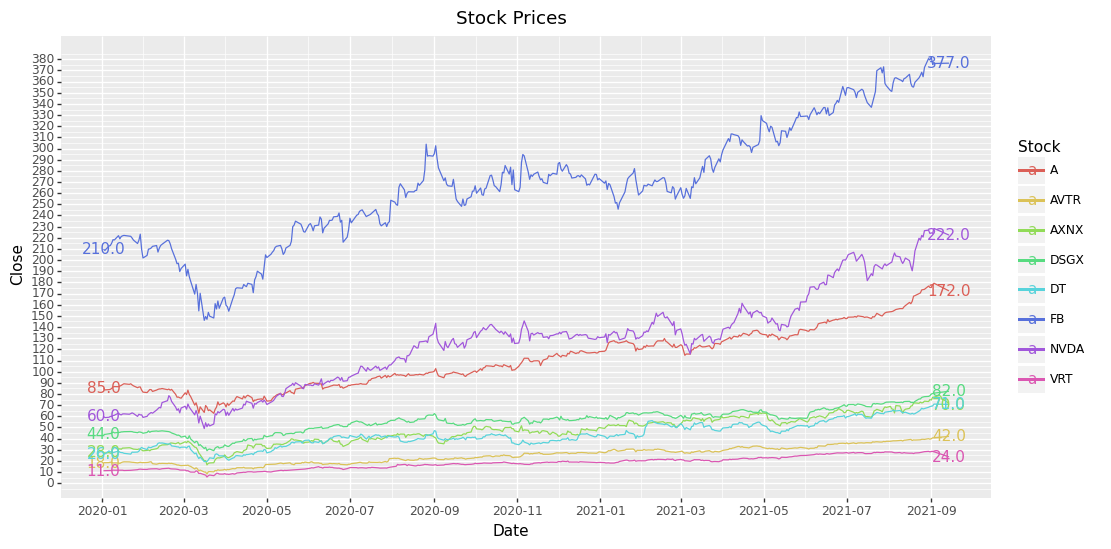

<ggplot: (8731729206321)>


In [153]:
df_temp=df.loc[df.Stock.isin(['NVDA','DT','A','VRT','DSGX','AXNX','AVTR','FB']),:] # 'CRM','MSFT','CRL',
print(
    ggplot(df_temp,
           aes('Date','Close',color='Stock'))
    +geom_line()
    +geom_text(aes(label='close_re'),
              df_temp.loc[(df_temp.Date==df_temp.Date.max())|
                          (df_temp.Date==df_temp.Date.min())
                          ,:].assign(close_re=lambda x:round(x.Close,0))
              )
    +scale_x_datetime(date_labels='%Y-%m')
    +scale_y_continuous(breaks=np.arange(0,df_temp.Close.max(),10))
    +theme(figure_size=(12,6))
    +labs(title='Stock Prices')
)

### Parallel Processing 
*  Parallel with dask: https://github.com/dask/dask-tutorial/blob/main/01_dask.delayed.ipynb

In [16]:
from dask import delayed # conda install dask
from dask.distributed import Client, LocalCluster
#client=Client(n_workers=2)
#LocalCluster() 

In [19]:
client=Client(n_workers=16)

In [ ]:
col=[]
for i in df.Stock.unique():
    benchmark=df.loc[df.Stock=='MSFT','Close'].reset_index(drop=True)
    if i=='MSFT':
        continue
    corr_coef=delayed(pd.Series.corr)(benchmark, 
                                      df.loc[df.Stock==i,'Close'].reset_index(drop=True))
    result={'Stock':i,
            'Close_corr':corr_coef}
    col.append(result)

total=delayed(pd.DataFrame)(col)
corr_output=total.compute()


In [18]:
client.close()

# Linear Regression

In [35]:
import statsmodels.formula.api as smf

## 01 Data Preprocessing 

In [40]:
df_1=df.copy()
df_1.loc[:,'REPORT_DATE']=df_1.loc[:,'Date']
## Calculating Days
df_1.loc[:,'Days']=df_1.groupby('Stock').REPORT_DATE.transform(lambda x:x.rank(method='dense',ascending=True))


## 02 Regression 

In [59]:
curr_time=datetime.datetime.now()

col_model=[]
for v in df_1.Stock.unique():
    sub_df=df_1.loc[df_1.Stock==v,:].sort_values(by='Date',ascending=True).reset_index(drop=True)
    lr_model=smf.ols('Close ~ Days',data=sub_df).fit()
    
    model_result={'Stock':v,
                  'R_squared':lr_model.rsquared,
                  'Coef':lr_model.params[1],
                  'Start_Date':sub_df.loc[0,'Date'],
                  'End_Date':sub_df.iloc[-1,:]['Date'],
                  'Start_Price':sub_df.loc[0,'Close'],
                  'End_Price':sub_df.iloc[-1,:].Close,
                  'Num_records':sub_df.shape[0],
                  'Num_records_2':sub_df.Date.nunique()
                  
                 }
    
    col_model.append(model_result)
    
print(datetime.datetime.now()-curr_time)

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49494 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49496 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49498 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49500 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49502 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49504 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49506 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49508 remote=tcp://127.0.0.1:38403>
distribu

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49628 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49630 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49632 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49634 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49636 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49638 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49640 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49642 remote=tcp://127.0.0.1:38403>
distribu

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49762 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49764 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49766 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49768 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49770 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49772 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49774 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49776 remote=tcp://127.0.0.1:38403>
distribu

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49896 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49898 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49900 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49902 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49904 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49906 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49908 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49910 remote=tcp://127.0.0.1:38403>
distribu

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50030 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50032 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50034 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50036 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50038 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50040 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50042 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50044 remote=tcp://127.0.0.1:38403>
distribu

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50164 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50166 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50168 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50170 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50172 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50174 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50176 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50178 remote=tcp://127.0.0.1:38403>
distribu

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50298 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50300 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50302 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50304 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50306 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50308 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50310 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50312 remote=tcp://127.0.0.1:38403>
distribu

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50432 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50434 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50436 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50438 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50440 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50442 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50444 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50446 remote=tcp://127.0.0.1:38403>
distribu

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50574 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50576 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50578 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50580 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50582 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50584 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50586 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50588 remote=tcp://127.0.0.1:38403>
distribu

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50708 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50710 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50712 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50714 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50716 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50718 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50720 remote=tcp://127.0.0.1:38403>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50722 remote=tcp://127.0.0.1:38403>
distribu

0:14:31.497790


/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50790 remote=tcp://127.0.0.1:38403>


In [4]:
col_model_2=pd.read_csv('/home/ubuntu/Python_Projects/Stock_Price_Prediction/data/analytics_result/linear_reg_results.csv')

#col_model_2=pd.DataFrame(col_model)
## Saving
#col_model_2.to_csv('/home/ubuntu/Python_Projects/Stock_Price_Prediction/data/analytics_result/linear_reg_results.csv',
#                   index=False)
print(col_model_2.shape)
print(col_model_2.Stock.nunique())

(5991, 9)
5991


## 03 Analysis

### Data Cleaning 

In [154]:
col_model_2.sort_values(by='R_squared',ascending=False)

,Stock,R_squared,Coef,Start_Date,End_Date,Start_Price,End_Price,Num_records,Num_records_2
1005,ENVB,1.000000e+00,-1.010000,2021-01-04,2021-09-14,3.980000,2.970000,2,2
910,DPRO,1.000000e+00,-0.240000,2021-07-30,2021-09-14,3.800000,3.560000,2,2
656,CLNN,1.000000e+00,-0.260000,2021-01-04,2021-09-14,7.570000,7.310000,2,2
5489,SE,9.631383e-01,0.701782,2020-01-02,2021-09-14,40.040001,333.549988,423,423
4804,LFT,9.603078e-01,0.007905,2020-06-30,2021-09-14,2.364295,3.990000,298,298
...,...,...,...,...,...,...,...,...,...
4117,DMS,6.428270e-08,0.000004,2020-01-02,2021-09-14,10.350000,7.040000,420,420
5584,SR,5.040268e-09,-0.000005,2020-01-02,2021-09-14,78.055885,62.869999,424,424
5988,MCAF,-inf,4.880000,2021-09-14,2021-09-14,9.760000,9.760000,1,1
5989,OEG,-inf,1.560000,2021-09-14,2021-09-14,3.120000,3.120000,1,1


In [155]:
col_model_2.loc[col_model_2.Num_records!=col_model_2.Num_records_2]

,Stock,R_squared,Coef,Start_Date,End_Date,Start_Price,End_Price,Num_records,Num_records_2


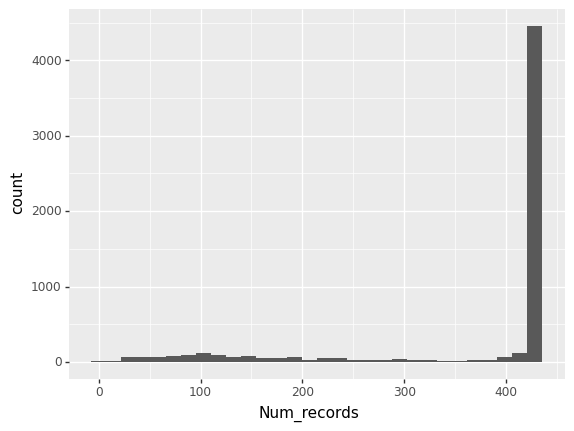

<ggplot: (8731728265761)>


In [156]:
## Num_records distribution
print(
    ggplot(col_model_2,aes('Num_records'))
    +geom_histogram(bins=30)
)

In [8]:
## Only consider >100
col_model_fil=col_model_2.loc[col_model_2.Num_records>=100,:].reset_index(drop=True)
print(col_model_fil.shape)

(5555, 9)


In [9]:
## Merge with info
col_model_fil=pd.merge(col_model_fil,
                       com_map.loc[:,['Symbol','Name','Sector','Industry','SE']],
                       how='left',
                       left_on='Stock',right_on='Symbol'
                      )
print(col_model_fil.shape)
print(col_model_fil.Stock.nunique())

(5555, 14)
5555


In [11]:
## Calculate weighted Coef
col_model_fil.loc[:,'wt_Coef']=col_model_fil.R_squared*col_model_fil.Coef
#col_model_fil.to_csv('/home/ubuntu/Python_Projects/Stock_Price_Prediction/data/analytics_result/linear_reg_results_filtered.csv',
#                    index=False)

### Analyzing 

In [159]:
## R_squared and Coef distribution
col_model_fil.loc[:,['R_squared','Coef']].describe()

,R_squared,Coef
count,5.555000e+03,5555.000000
mean,4.469730e-01,0.008934
std,2.760174e-01,3.760988
min,5.040268e-09,-243.999525
25%,2.005110e-01,0.001025
50%,4.716821e-01,0.014194
75%,6.872602e-01,0.049965
max,9.631383e-01,101.626236


#### 01. Build a profolio that doesn't own the whole stock 

In [28]:
## rank by wt_coef
profolio_partial=col_model_fil.sort_values(by='wt_Coef',ascending=False).head(25)
profolio_partial.Sector.value_counts()

Technology           6
Health Care          4
Finance              4
Consumer Services    4
Capital Goods        2
Energy               1
Transportation       1
Name: Sector, dtype: int64

In [29]:
profolio_partial

,Stock,R_squared,Coef,Start_Date,End_Date,Start_Price,End_Price,Num_records,Num_records_2,Symbol,Name,Sector,Industry,SE,wt_Coef
2499,SCR,0.637444,101.626236,2021-02-23,2021-09-14,8450.000000,11500.000000,139,139,SCR,Score Media and Gaming Inc. Class A Subordinat...,None,None,NASDAQ,64.781001
4743,NVR,0.719497,4.970474,2020-01-02,2021-09-14,3735.500000,4958.589844,423,423,NVR,NVR Inc. Common Stock,Capital Goods,Homebuilding,NYSE,3.576239
1203,GOOG,0.876698,3.711630,2020-01-02,2021-09-14,1367.369995,2868.120117,424,424,GOOG,Alphabet Inc. Class C Capital Stock,Technology,Internet and Information Services,NASDAQ,3.253977
1204,GOOGL,0.876541,3.581791,2020-01-02,2021-09-14,1368.680054,2850.889893,424,424,GOOGL,Alphabet Inc. Class A Common Stock,Technology,Internet and Information Services,NASDAQ,3.139587
175,AMZN,0.730067,3.671435,2020-01-02,2021-09-14,1898.010010,3450.000000,429,429,AMZN,Amazon.com Inc. Common Stock,Consumer Services,Catalog/Specialty Distribution,NASDAQ,2.680392
1776,MELI,0.775146,3.067222,2020-01-02,2021-09-14,610.190002,1856.339966,424,424,MELI,MercadoLibre Inc. Common Stock,Consumer Services,Catalog/Specialty Distribution,NASDAQ,2.377544
5103,SHOP,0.868287,2.546581,2020-01-02,2021-09-14,407.809998,1451.280029,424,424,SHOP,Shopify Inc. Class A Subordinate Voting Shares,None,None,NYSE,2.211163
3624,CMG,0.850839,2.372296,2020-01-02,2021-09-14,858.190002,1859.790039,423,423,CMG,Chipotle Mexican Grill Inc. Common Stock,Consumer Services,Restaurants,NYSE,2.018442
5301,TPL,0.651217,2.894460,2020-01-02,2021-09-14,742.016052,1215.089966,424,424,TPL,Texas Pacific Land Corporation Common Stock,Energy,Oil & Gas Production,NYSE,1.884920
4592,MTD,0.916523,2.003578,2020-01-02,2021-09-14,805.059998,1559.439941,423,423,MTD,Mettler-Toledo International Inc. Common Stock,Health Care,Medical Specialities,NYSE,1.836325


#### 02 Profolio that owns the whole stock 

In [33]:
profolio_full=col_model_fil.loc[(col_model_fil.End_Price<=200)&
                                (col_model_fil.Coef>=0.05)&
                                (col_model_fil.R_squared>=0.9)
                                ,:].sort_values(by='wt_Coef',ascending=False)
print(profolio_full.shape)
profolio_full.head(25)

(55, 15)


,Stock,R_squared,Coef,Start_Date,End_Date,Start_Price,End_Price,Num_records,Num_records_2,Symbol,Name,Sector,Industry,SE,wt_Coef
1037,FIVN,0.905000,0.316686,2020-01-02,2021-09-14,66.760002,167.990005,423,423,FIVN,Five9 Inc. Common Stock,Technology,EDP Services,NASDAQ,0.286601
2665,STAA,0.910625,0.310368,2020-01-02,2021-09-14,34.790001,139.539993,424,424,STAA,STAAR Surgical Company Common Stock,Health Care,Ophthalmic Goods,NASDAQ,0.282629
5329,TT,0.901201,0.293106,2020-01-02,2021-09-14,101.597382,183.740005,423,423,TT,Trane Technologies plc,Capital Goods,Auto Parts:O.E.M.,NYSE,0.264148
3969,FERG,0.913247,0.286294,2020-09-10,2021-09-14,89.900963,145.199997,186,186,FERG,Ferguson plc Ordinary Shares,Consumer Durables,Industrial Machinery/Components,NYSE,0.261458
3757,DEN,0.928489,0.281009,2020-09-21,2021-09-14,18.100000,66.949997,242,242,DEN,Denbury Inc. Common Stock,Energy,Oil & Gas Production,NYSE,0.260914
1773,MEDP,0.911278,0.283090,2020-01-02,2021-09-14,82.970001,181.070007,423,423,MEDP,Medpace Holdings Inc. Common Stock,Health Care,Biotechnology: Commercial Physical & Biologica...,NASDAQ,0.257974
1569,KRNT,0.928675,0.254633,2020-01-02,2021-09-14,33.779999,140.960007,423,423,KRNT,Kornit Digital Ltd. Ordinary Shares,Capital Goods,Industrial Machinery/Components,NASDAQ,0.236471
1103,FSV,0.904474,0.253146,2020-01-02,2021-09-14,92.491524,182.500000,423,423,FSV,FirstService Corporation Common Shares,None,None,NASDAQ,0.228964
4650,NET,0.913981,0.247911,2020-01-02,2021-09-14,17.030001,126.760002,424,424,NET,Cloudflare Inc. Class A Common Stock,Technology,EDP Services,NYSE,0.226585
5492,WMS,0.923359,0.237573,2020-01-02,2021-09-14,38.956856,112.830002,423,423,WMS,Advanced Drainage Systems Inc. Common Stock,Capital Goods,Building Products,NYSE,0.219365


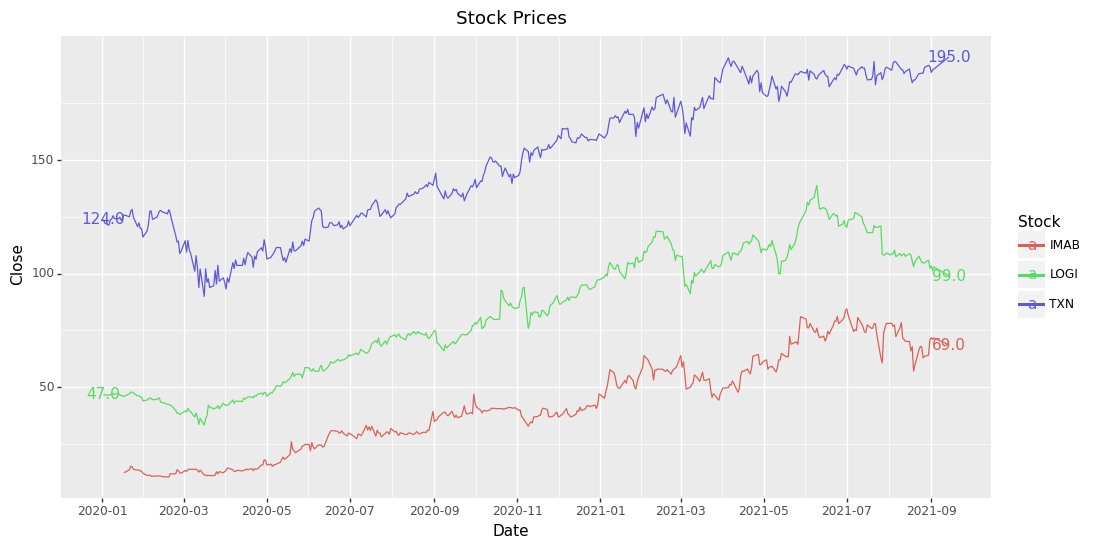

<ggplot: (8774576797269)>


In [37]:
## Viz
df_temp=df.loc[df.Stock.isin(['TXN','LOGI','IMAB']),:] # 'CRM','MSFT','CRL',
print(
    ggplot(df_temp,
           aes('Date','Close',color='Stock'))
    +geom_line()
    +geom_text(aes(label='close_re'),
              df_temp.loc[(df_temp.Date==df_temp.Date.max())|
                          (df_temp.Date==df_temp.Date.min())
                          ,:].assign(close_re=lambda x:round(x.Close,0))
              )
    +scale_x_datetime(date_labels='%Y-%m')
    +scale_y_continuous(breaks=np.arange(0,df_temp.Close.max(),50))
    +theme(figure_size=(12,6))
    +labs(title='Stock Prices')
)

In [ ]:
## Add last 30 days moving average 